In [9]:
# download the sample image
!wget --no-check-certificate \
    https://drive.google.com/uc?id=15ywep3yQV_hb5J1n4vVkS0nT5XdJhJ-B -O connectivity.png

--2024-11-02 21:17:27--  https://drive.google.com/uc?id=15ywep3yQV_hb5J1n4vVkS0nT5XdJhJ-B
Resolving drive.google.com (drive.google.com)... 74.125.141.139, 74.125.141.101, 74.125.141.113, ...
Connecting to drive.google.com (drive.google.com)|74.125.141.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=15ywep3yQV_hb5J1n4vVkS0nT5XdJhJ-B [following]
--2024-11-02 21:17:27--  https://drive.usercontent.google.com/download?id=15ywep3yQV_hb5J1n4vVkS0nT5XdJhJ-B
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 173.194.216.132, 2607:f8b0:400c:c12::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|173.194.216.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2136 (2.1K) [image/png]
Saving to: ‘connectivity.png’

connectivity.png    100%[===================>]   2.09K  --.-KB/s    in 0s      

2024-11-02 21:17:29 (19.9 MB/s) - ‘connectivi

In [10]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
%matplotlib inline
from matplotlib import pyplot as plt

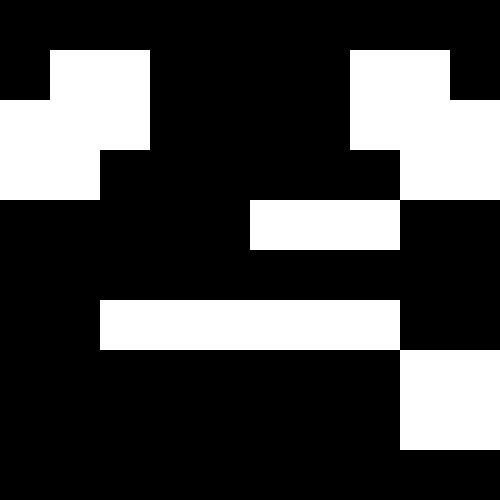

Image height= 500 px, and width= 500 px and data type: uint8


In [11]:
# load and display the sample image
image = cv2.imread('connectivity.png', cv2.IMREAD_GRAYSCALE)
cv2_imshow(image)

height, width = image.shape
print("Image height=", height, "px, and width=", width, "px and data type:", image.dtype)

In this homework, your task is to implement the **two-pass algorithm** to label connected components in a binary image. The provided code includes a function that returns the output from OpenCV. You are expected to replace this OpenCV call with your own implementation. Additionally, I have included code to test and visualize the output. You should only implement the function below.

**Note:**Please test your implementation with various images.

In [13]:
def two_pass_connected_components(image, connectivity=4):
  """
  Implement the two-pass algorithm for connected component extraction.

  This function takes a binary image and extracts all the connected components based on given connectivity.

  Parameters:
  -----------
  image : numpy.ndarray
      A binary (grayscale) image where connected components will be labeled.
      It should contain binary values (e.g., 0 for background and 1 for foreground).

  connectivity : int, optional, default=4
      Connectivity determines how neighbors are defined:
      - connectivity=4: Considers only the four directly adjacent neighbors (top, bottom, left, right).
      - connectivity=8: Considers all eight surrounding pixels.

  Returns:
  --------
  num_labels : int
      The total number of labels, including the background label (typically 0).

  labels : numpy.ndarray
      A labeled image where each connected component is marked with a unique integer label.
      The background is labeled as 0.

  # Expected output (use OpenCV's function only to verify output as a reference)
  # num_labels, labels = cv2.connectedComponents(binary_image, connectivity)
  """

  # Making sure the picture is binary
  image = (image > 0).astype(int)

  # Initializing the labeled array and a dictionary for Union-Find equivalence handling
  labeled_array = np.zeros(image.shape, dtype=int)
  parent = {}
  current_label = 1

  # Helper functions for Union-Find operations retrieved from the algorithm in the slides
  def find(x):
      if parent[x] != x:
          parent[x] = find(parent[x])  # Path compression
      return parent[x]

  def union(x, y):
      root_x = find(x)
      root_y = find(y)
      if root_x != root_y:
          parent[root_y] = root_x

  # First pass: Labeling the components and recording equivalences
  for x in range(image.shape[0]):
      for y in range(image.shape[1]):
          if image[x, y] == 1:  # Foreground pixel which is important for us to process
              neighbors = []

              # 4-connectivity: top and left neighbors, since they were processed before
              if connectivity == 4:
                  if x > 0:  # Top neighbor
                      neighbors.append(labeled_array[x - 1, y])
                  if y > 0:  # Left neighbor
                      neighbors.append(labeled_array[x, y - 1])

              # 8-connectivity: all surrounding neighbors
              elif connectivity == 8:
                  for dx in [-1, 0, 1]:
                      for dy in [-1, 0, 1]:
                          if dx == 0 and dy == 0:
                              continue
                          nx, ny = x + dx, y + dy
                          if 0 <= nx < image.shape[0] and 0 <= ny < image.shape[1]:
                              neighbors.append(labeled_array[nx, ny])

              # Getting unique non-zero neighbor labels
              neighbor_labels = list(set(n for n in neighbors if n > 0))  # Using set to avoid duplicates

              if not neighbor_labels:
                  # If there is no connected neighbors, assign a new label
                  labeled_array[x, y] = current_label
                  parent[current_label] = current_label  # Initializing the parent
                  current_label += 1
              else:
                  # Useing the smallest label and union all neighbors
                  min_label = min(neighbor_labels)
                  labeled_array[x, y] = min_label
                  for label in neighbor_labels:
                      if label not in parent:
                          parent[label] = label  # Ensuring each label has a parent
                      union(min_label, label)

  # Second pass: Relabeling the components
  for x in range(image.shape[0]):
      for y in range(image.shape[1]):
          if labeled_array[x, y] > 0:
              # Relabel with the root label
              labeled_array[x, y] = find(labeled_array[x, y])

  # Mapping old labels to a consecutive range for compactness
  unique_labels = np.unique(labeled_array)
  label_map = {old_label: new_label for new_label, old_label in enumerate(unique_labels)}
  labeled_array = np.vectorize(label_map.get)(labeled_array)

  num_labels = len(unique_labels)

  return num_labels, labeled_array


  # Replace this with your own implementation

  #def two_pass_connected_components(image, connectivity=4):
  #return cv2.connectedComponents(image, connectivity)


In [14]:
num_labels_4, labels_4 = two_pass_connected_components(image)
output_image_4 = np.zeros((labels_4.shape[0], labels_4.shape[1], 3), dtype=np.uint8)

num_labels_8, labels_8 = two_pass_connected_components(image, connectivity=8)
output_image_8 = np.zeros((labels_8.shape[0], labels_8.shape[1], 3), dtype=np.uint8)

colors_4 = np.random.randint(0, 255, size=(num_labels_4, 3))
for label in range(1, num_labels_4):
    output_image_4[labels_4 == label] = colors_4[label]


colors_8 = np.random.randint(0, 255, size=(num_labels_8, 3))
for label in range(1, num_labels_8):
    output_image_8[labels_8 == label] = colors_8[label]

In [15]:
print(num_labels_4)
print(num_labels_8)

6
4


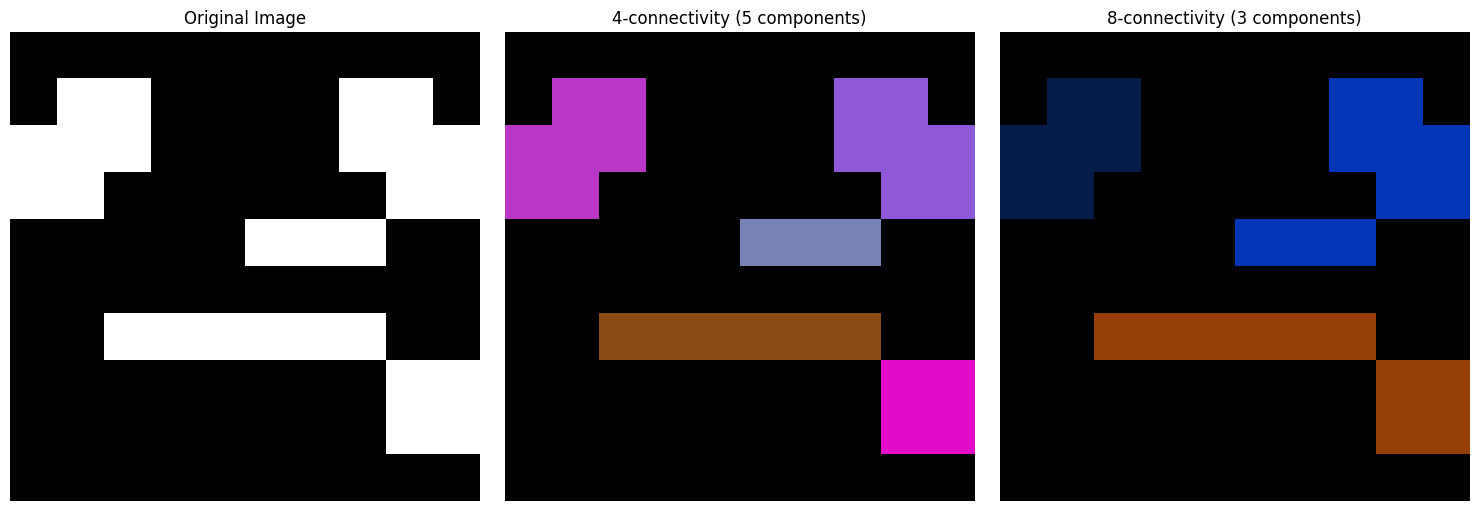

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(output_image_4, cmap='gray')
axes[1].set_title(f"4-connectivity ({num_labels_4 - 1} components)")
axes[1].axis('off')

axes[2].imshow(output_image_8, cmap='gray')
axes[2].set_title(f"8-connectivity ({num_labels_8 - 1} components)")
axes[2].axis('off')


plt.tight_layout()
plt.show()